In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import time

import gym
import numpy as np
import os
import ptan

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import collections
import seaborn as sns

sns.set_style('darkgrid')

In [174]:
class OrbitalDynamicsEnv(gym.Env):
    metadata = {'render.modes': ['human']}
    
    # dt_s -- is the time step in seconds.
    def __init__(self, planet_Mass_kg = 5.972*10**(24), planet_R_km = 6371.0, 
                 dt_s = 1.0, target_r = 2.0, thrust_gs= 1.25, verbose = False, 
                 record_history = True, record_rate = 100):
        
        super(OrbitalDynamicsEnv, self).__init__()
        self.record_rate = record_rate
    
        # Actions
        self.action_space = gym.spaces.Box(low=np.array([0, -100.0]), 
                                           high=np.array([100.0, 100.0]), 
                                           dtype=np.float32)
        
        # Obs (r,rdot,theta,theta_dot)
        self.observation_space = gym.spaces.Box(low=np.array([0., -10., 0.0, -10.0]), 
                                                high=np.array([10., 10., 2*np.pi, 10.0]), 
                                                dtype=np.float32)
        
        self.record_history = record_history
        
        # Newton's Gravitational Constant in SI units
        G = 6.674*10**(-11) # m^3 kg^-1 s^-2 
        
        # Convert to Natural Problem Units
        # tn_s = (R^3/GM)^1/2 -- where all measures are in SI units
        planet_R_m = planet_R_km*10**3
        tn_s = (planet_R_m**3/(G*planet_Mass_kg))**0.5
        
        # define the time step in seconds
        self.dts = dt_s
        # define the natural length in meters
        self.ln_m = planet_R_m
        # convert the time step in seconds to natural time
        self.dt = dt_s/tn_s
        
        if verbose:
            print('Units')
            print('-----')
            print('\ttime: 1 s = ', 1.0/tn_s,' tn')
            print('\tlength: 1 m = ',1.0/planet_R_m,' ln')
            print('Simulation parameters')
            print('-----')
            print('\tnatural units time step size: ',self.dt)
        
        # setting the target altitude in natural units
        self.target_r = target_r
        self.max_r = 2.0*target_r
        
        # solving the oribital angular velocity in natural units
        self.orbit_theta_dot = target_r**(-1.5)
        self.max_theta_dot = 10.0*self.orbit_theta_dot
        
        # solving the maxium allowable natural time to run an episode
        self.max_time = 2*np.pi*target_r**(1.5)
        # adding in a buffer to allow it to go a little longer
        self.max_time = 5*self.max_time
        # solving the maximum allowable steps given the max time
        self.max_steps = np.int32(np.ceil(self.max_time/self.dt))
        
        if verbose:
            print('\ttarget theta dot: ', self.orbit_theta_dot, ' 1/tn')
            print('\tmax allowable natural time: ', self.max_time, " tn = ", self.max_time*tn_s," s")
            print('\tmax allowed steps: ', self.max_steps)
            
        
        # max accleration from thrust in natural units (ln/tn^2)
        # 1 g = GM/R_planet^2 --in natural units--> 1 g = (ln^3/tn^2)/(ln^2)
        # 1 g. = 1 ln/tn^2
        self.max_thrust = thrust_gs
        self.max_o_thrust = 0.5
        
        if verbose:
            print('Policy Parameters')
            print('-----')
            max_thrust_SI = self.max_thrust*(self.ln_m)/(tn_s**2)
            # as a reference https://www.nasa.gov/pdf/466711main_AP_ST_ShuttleAscent.pdf
            # says the spaceshuttle never exceeded 3gs or ~ 30 m/s^2
            print('\tDiscrete thrust acceleration: ', self.max_thrust,' ln/tn^2 = ', max_thrust_SI,' m/s^2')
        
    def reset(self):
        # Reset the state of the environment to an initial state
        self.steps = 0
        
        # Orientation Coordinate in global coordinates
        self.orientation_rate = 0.0
        self.orientation_angle = 0.1
        
        # Translational Coordinates
        self.r = 1.0
        self.r_dot = 0.0
        self.r_double_dot = 0.0
        
        self.theta = 0.0
        self.theta_dot = 0.0 # can change this if u want to add planetary rotation
        self.theta_double_dot = 0.0
        
        self.elapsed_time = 0.0 # elapsed sim time in natural units
        self.elapsed_time_s = 0.0 # elapsed sim time in seconds
        
        # initialize the history array
        if self.record_history:
            self.trajectory = np.array([[self.r*np.cos(self.theta), self.r*np.sin(self.theta), 
                                         self.orientation_angle]])
        
        obs = np.array([self.r, self.r_dot, self.theta, self.theta_dot])
        
        return obs
    
    # continous actions = (mean thrust, mean counter clockwise rotation thrust)
    def step(self, action):
        self.steps += 1
        
        # actions segragation
        thrust = np.clip(action[0], 0.0, self.max_thrust)
        orientation_thrust = np.clip(action[1], -self.max_o_thrust, self.max_o_thrust) 
        
        # Translating the actions into the planet centric coordinate system
        action_vector = thrust*np.array([np.cos(self.orientation_angle), 
                                         np.sin(self.orientation_angle)])
        
        # Apply the orientation action prior to the state propagator
        self.orientation_angle += self.orientation_rate*self.dt + 0.5*orientation_thrust*self.dt**2
        self.orientation_rate += orientation_thrust*self.dt

        # current r hat vector and theta hat vector
        r_vect = np.array([np.cos(self.theta), np.sin(self.theta)])
        theta_vect = np.array([-np.sin(self.theta), np.cos(self.theta)])
        
        # projection of actions along r and theta 
        action_along_r = np.dot(r_vect, action_vector)
        action_along_theta = np.dot(theta_vect, action_vector)
        
        # Execute one time step within the environment using RK4
        self.elapsed_time += self.dt
        self.elapsed_time_s += self.dts

        # integrate
        y0_k1 = self.r_dot
        y1_k1 = self.r*self.r_dot**2 - 1./self.r**2 + action_along_r
        y2_k1 = self.theta_dot
        y3_k1 = -2.0*self.r_dot/self.r*self.theta_dot + action_along_theta
        
        y0_k2 = (self.r_dot + y1_k1*self.dt/2)
        y1_k2 = (self.r + y0_k1*self.dt/2)*(self.r_dot + y1_k1*self.dt/2)**2 - 1./(self.r + y0_k1*self.dt/2)**2 + action_along_r
        y2_k2 = (self.theta_dot + y3_k1*self.dt/2)
        y3_k2 = -2.0*(self.r_dot + y1_k1*self.dt/2)/(self.r + y0_k1*self.dt/2)*(self.theta_dot + y3_k1*self.dt/2) + action_along_theta
        
        y0_k3 = (self.r_dot + y1_k2*self.dt/2)
        y1_k3 = (self.r + y0_k2*self.dt/2)*(self.r_dot + y1_k2*self.dt/2)**2 - 1./(self.r + y0_k2*self.dt/2)**2 + action_along_r
        y2_k3 = (self.theta_dot + y3_k1*self.dt/2)
        y3_k3 = -2.0*(self.r_dot + y1_k2*self.dt/2)/(self.r + y0_k2*self.dt/2)*(self.theta_dot + y3_k2*self.dt/2) + action_along_theta
        
        y0_k4 = (self.r_dot + y1_k3*self.dt)
        y1_k4 = (self.r + y0_k3*self.dt)*(self.r_dot + y1_k3*self.dt)**2 - 1./(self.r + y0_k3*self.dt)**2 + action_along_r
        y2_k4 = (self.theta_dot + y3_k1*self.dt/2)
        y3_k4 = -2.0*(self.r_dot + y1_k2*self.dt/2)/(self.r + y0_k2*self.dt/2)*(self.theta_dot + y3_k2*self.dt) + action_along_theta
        
        
        # Update 
        self.r = self.r + self.dt/6*(y0_k1 + 2*y0_k2 + 2*y0_k3 + y0_k4)
        self.r_dot = self.r_dot + self.dt/6*(y1_k1 + 2*y1_k2 + 2*y1_k3 + y0_k4)

        self.theta = self.theta + self.dt/6*(y2_k1 + 2*y2_k2 + 2*y2_k3 + y2_k4)
        self.theta_dot = self.theta_dot + self.dt/6*(y3_k1 + 2*y3_k2 + 2*y3_k3 + y3_k4)
        
        # prepare to output
        obs = np.array([self.r,self.r_dot,self.theta,self.theta_dot])
        
        # If recording is enabled record the trajectory
        if (self.record_history) and (self.steps % self.record_rate == 0):
            self.trajectory = np.append(self.trajectory, 
                                        [[self.r*np.cos(self.theta), 
                                          self.r*np.sin(self.theta), 
                                          self.orientation_angle]], 
                                        axis=0)
        
        # GET TO THE TARGET ALT BY USING THE LEAST THRUST
        reward = np.min( [(0.01)**-2, (self.r - self.target_r)**-2] )
        
        # set if at the terminal state
        done = False
            
        if (self.r < 1.0):
            done = True
        
        if self.steps > self.max_steps:
            done = True
        
        if (self.r > self.max_r) or (np.abs(self.theta_dot) > self.max_theta_dot):
            done = True
        
        return (obs, reward, done, {})
    
    def render(self, size=5, sample_traj_rate = 1):
        
        fig = plt.figure(figsize=(size,size), dpi=100)
        ax = fig.add_subplot(111)
        ax.set_aspect(1) 
        
        # Planet Surface
        x = np.linspace(-1,1,100,endpoint=True)
        plt.plot(x, np.sqrt(1-x**2), c='k')
        plt.plot(x,-np.sqrt(1-x**2), c ='k')
        
        # Trajectory
        plt.plot(self.trajectory[::sample_traj_rate,0], self.trajectory[::sample_traj_rate,1], c='b')
        
        # orientation vector every Nth
        xaxis_orientation = self.trajectory[::sample_traj_rate,2]
        # vector terminal pts
        start_pts = self.trajectory[::sample_traj_rate,[0,1]]
        end_pts = start_pts + 0.05*np.dstack((np.cos(xaxis_orientation), np.sin(xaxis_orientation)))[0]
        
        for idx in range(len(start_pts)):
            plt.plot([start_pts[idx,0],end_pts[idx,0]], [start_pts[idx,1],end_pts[idx,1]], c='r')
        plt.show();
        
        fig, axs = plt.subplots(3, sharex=False, sharey=False, figsize=(size,size), dpi=100)
        axs[0].plot(np.sqrt(self.trajectory[::sample_traj_rate,0]**2+self.trajectory[::sample_traj_rate,1]**2), c='b')
        axs[0].set_ylabel('altitude (ln)')
        axs[0].set_xlabel('time (steps)')
        
        axs[1].plot(np.arctan2(self.trajectory[::sample_traj_rate,1],self.trajectory[::sample_traj_rate,0])*180/np.pi, c='b')
        axs[1].set_ylabel('latitude (degrees)')
        axs[1].set_xlabel('time (steps)')
        
        axs[2].plot((self.trajectory[::sample_traj_rate,2]*180/np.pi) % 360, c='b')
        axs[2].set_ylabel('orientation to x-axis (degrees)')
        axs[2].set_xlabel('time (steps)')
        plt.tight_layout()

In [175]:
env = OrbitalDynamicsEnv(dt_s = 10.0, target_r = 2.0, thrust_gs= 1.50, record_history=False)
test_env = OrbitalDynamicsEnv(dt_s = 10.0, target_r = 2.0, thrust_gs= 1.50, record_history=True, verbose=True, record_rate = 5)

Units
-----
	time: 1 s =  0.0012414853327976582  tn
	length: 1 m =  1.5696123057604772e-07  ln
Simulation parameters
-----
	natural units time step size:  0.012414853327976583
	target theta dot:  0.3535533905932738  1/tn
	max allowable natural time:  88.85765876316732  tn =  71573.6677798107  s
	max allowed steps:  7158
Policy Parameters
-----
	Discrete thrust acceleration:  1.5  ln/tn^2 =  14.729298049223939  m/s^2


In [176]:
def test_net(net, env, count=10, device="cpu"):
    rewards = 0.0
    steps = 0
    for _ in range(count):
        obs = env.reset()
        while True:
            obs_v = ptan.agent.float32_preprocessor([obs]).to(device)
            mu_v = net(obs_v)
            action = mu_v.squeeze(dim=0).data.cpu().numpy()
            obs, reward, done, _ = env.step(action)
            rewards += reward
            steps += 1
            if done:
                break
    return rewards / count, steps / count

def unpack_batch_ddqn(batch, device="cpu"):
    states, actions, rewards, dones, last_states = [], [], [], [], []
    for exp in batch:
        states.append(exp.state)
        actions.append(exp.action)
        rewards.append(exp.reward)
        dones.append(exp.last_state is None)
        if exp.last_state is None:
            last_states.append(exp.state)
        else:
            last_states.append(exp.last_state)
    states_v = ptan.agent.float32_preprocessor(states).to(device)
    actions_v = ptan.agent.float32_preprocessor(actions).to(device)
    rewards_v = ptan.agent.float32_preprocessor(rewards).to(device)
    last_states_v = ptan.agent.float32_preprocessor(last_states).to(device)
    dones_t = torch.LongTensor(dones).to(device)
    return states_v, actions_v, rewards_v, dones_t, last_states_v


HIDDEN_SIZE = 128

class DDPGActor(nn.Module):
    def __init__(self, obs_size, act_size):
        super(DDPGActor, self).__init__()

        self.thruster = nn.Sequential(
            nn.Linear(obs_size, HIDDEN_SIZE),
            nn.ReLU(),
            nn.Linear(HIDDEN_SIZE, 1)
        )
        
        self.rotation = nn.Sequential(
            nn.Linear(obs_size, HIDDEN_SIZE),
            nn.ReLU(),
            nn.Linear(HIDDEN_SIZE, 1)
        )
    
    def forward(self, x):
        thrust = F.sigmoid(self.thruster(x))*env.max_thrust
        rotation = F.tanh(self.rotation(x))*env.max_o_thrust

        return torch.cat([thrust,rotation], dim=1)


class DDPGCritic(nn.Module):
    def __init__(self, obs_size, act_size):
        super(DDPGCritic, self).__init__()

        self.obs_net = nn.Sequential(
            nn.Linear(obs_size, HIDDEN_SIZE),
            nn.ReLU(),
        )

        self.out_net = nn.Sequential(
            nn.Linear(HIDDEN_SIZE + act_size, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x, a):
        obs = self.obs_net(x)
        return self.out_net(torch.cat([obs, a], dim=1))
    
class AgentDDPG(ptan.agent.BaseAgent):
    """
    Agent implementing Orstein-Uhlenbeck exploration process
    """
    def __init__(self, net, device="cpu", ou_enabled=True, ou_mu=0.0, 
                 ou_teta=0.0, ou_sigma=1.0, ou_epsilon=1.0):
        self.net = net
        self.device = device
        self.ou_enabled = ou_enabled
        self.ou_mu = ou_mu
        self.ou_teta = ou_teta
        self.ou_sigma = ou_sigma
        self.ou_epsilon = ou_epsilon

    def initial_state(self):
        return None

    def __call__(self, states, agent_states):
        states_v = ptan.agent.float32_preprocessor(states).to(self.device)
        mu_v = self.net(states_v)
        actions = mu_v.data.cpu().numpy()

        if self.ou_enabled:
            actions = actions + np.random.normal(0.0, self.ou_sigma)
            actions[:,0] = np.clip(actions[:,0], a_min=0.0, a_max=env.max_thrust)
            actions[:,1] = np.clip(actions[:,1], a_min=-env.max_o_thrust, a_max=env.max_o_thrust)
            new_a_states = actions
        else:
            new_a_states = agent_states

        return actions, new_a_states

In [177]:
GAMMA = 0.99
TAU = 0.01

BATCH_SIZE = 512
LEARNING_RATE = 1e-5

REPLAY_SIZE = 100000
REPLAY_INITIAL = 10000

TEST_ITERS = 1000

In [178]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

act_net = DDPGActor(env.observation_space.shape[0], env.action_space.shape[0]).to(device)
crt_net = DDPGCritic(env.observation_space.shape[0], env.action_space.shape[0]).to(device)

print(act_net)
print(crt_net)

tgt_act_net = ptan.agent.TargetNet(act_net)
tgt_crt_net = ptan.agent.TargetNet(crt_net)

agent = AgentDDPG(act_net, device=device)
agent.ou_sigma = np.array([1.0,1.0])

exp_source = ptan.experience.ExperienceSourceFirstLast(env, agent, gamma=GAMMA, steps_count=3)

buffer = ptan.experience.ExperienceReplayBuffer(exp_source, buffer_size=REPLAY_SIZE)

act_opt = optim.Adam(act_net.parameters(), lr=LEARNING_RATE)
crt_opt = optim.Adam(crt_net.parameters(), lr=LEARNING_RATE)

DDPGActor(
  (thruster): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
  (rotation): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)
DDPGCritic(
  (obs_net): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
  )
  (out_net): Sequential(
    (0): Linear(in_features=130, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [165]:
frame_idx = 0
best_reward = None

while True:
    frame_idx += 1
    buffer.populate(1)

    if len(buffer) < REPLAY_INITIAL:
        continue

    batch = buffer.sample(BATCH_SIZE)
    states_v, actions_v, rewards_v, dones_mask, last_states_v = \
        unpack_batch_ddqn(batch, device)

    # train critic
    crt_opt.zero_grad()

    q_v = crt_net(states_v, actions_v)
    last_act_v = tgt_act_net.target_model(last_states_v)

    q_last_v = tgt_crt_net.target_model(last_states_v, last_act_v)
    q_last_v[dones_mask] = 0.0
    q_ref_v = rewards_v.unsqueeze(dim=-1) + q_last_v * GAMMA

    critic_loss_v = F.mse_loss(q_v, q_ref_v.detach())
    critic_loss_v.backward()
    crt_opt.step()

    # train actor
    act_opt.zero_grad()

    cur_actions_v = act_net(states_v)
    actor_loss_v = -crt_net(states_v, cur_actions_v)
    actor_loss_v = actor_loss_v.mean()

    actor_loss_v.backward()
    act_opt.step()

    tgt_act_net.alpha_sync(alpha = 1. - TAU)
    tgt_crt_net.alpha_sync(alpha = 1. - TAU)

    if (frame_idx % TEST_ITERS) == 0:
        ts = time.time()
        rewards, steps = test_net(act_net, env, device=device)
        print("Test done in %.2f sec, avg reward %.6f, avg steps %d, frac of max %.5f" % 
              (time.time() - ts, rewards, steps, float(steps/env.max_steps)))

        if best_reward is None or best_reward < rewards:
            if best_reward is not None:
                print("Best reward updated: %.6f -> %.6f" % (best_reward, rewards))
                
            agent.ou_sigma = np.clip((1.-1./1e6)*agent.ou_sigma, a_min=0.1, a_max=np.inf)
            best_reward = rewards
        
        if best_reward > 1e4:
            print('solved.')
            break

Test done in 0.01 sec, avg reward 1.000, avg steps 1, frac of max 0.000
Test done in 0.01 sec, avg reward 1.000, avg steps 1, frac of max 0.000
Test done in 0.01 sec, avg reward 1.000, avg steps 1, frac of max 0.000
Test done in 0.01 sec, avg reward 1.000, avg steps 1, frac of max 0.000
Best reward updated: 1.000 -> 1.000
Test done in 0.01 sec, avg reward 1.000, avg steps 1, frac of max 0.000
Best reward updated: 1.000 -> 1.000
Test done in 0.01 sec, avg reward 1.000, avg steps 1, frac of max 0.000
Best reward updated: 1.000 -> 1.000
Test done in 0.01 sec, avg reward 1.000, avg steps 1, frac of max 0.000
Best reward updated: 1.000 -> 1.000
Test done in 0.23 sec, avg reward 25.006, avg steps 25, frac of max 0.003
Best reward updated: 1.000 -> 25.006
Test done in 0.32 sec, avg reward 38.060, avg steps 38, frac of max 0.005
Best reward updated: 25.006 -> 38.060
Test done in 0.36 sec, avg reward 44.137, avg steps 44, frac of max 0.006
Best reward updated: 38.060 -> 44.137
Test done in 0.38

KeyboardInterrupt: 

In [171]:
agent.ou_sigma

array([0.999961, 0.999961])

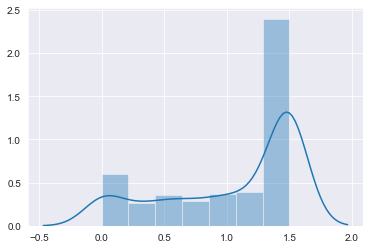

In [172]:
sns.distplot(actions_v[:,0].data.cpu().numpy())

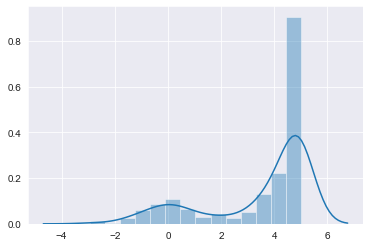

In [173]:
sns.distplot(actions_v[:,1].data.cpu().numpy())

In [166]:
s = test_env.reset()

traj_a = []
R = 0.0
while True:
    s_v = torch.FloatTensor([s]).to(device)
    a_v = act_net(s_v)
    a = a_v.data.cpu().numpy()[0]
    traj_a.append(a)
    s,r,d,_ = test_env.step(a)
    R += r
    if d:
        break

print(R)
traj_a = np.array(traj_a)

53.41102328220641


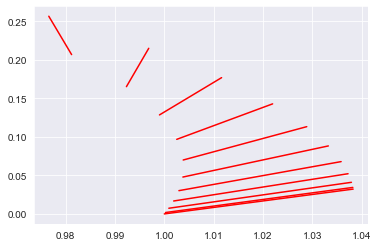

In [167]:
# orientation vector every Nth
xaxis_orientation = test_env.trajectory[:,2]
# vector terminal pts
start_pts = test_env.trajectory[:,[0,1]]
end_pts = start_pts + 0.05*np.dstack((np.cos(xaxis_orientation), np.sin(xaxis_orientation)))[0]

for idx in range(len(start_pts)):
    plt.plot([start_pts[idx,0],end_pts[idx,0]], [start_pts[idx,1],end_pts[idx,1]], c='r')
plt.show();

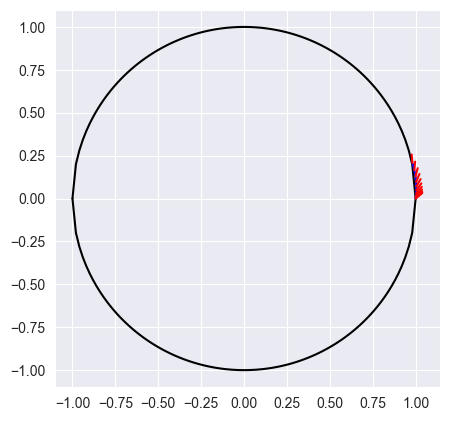

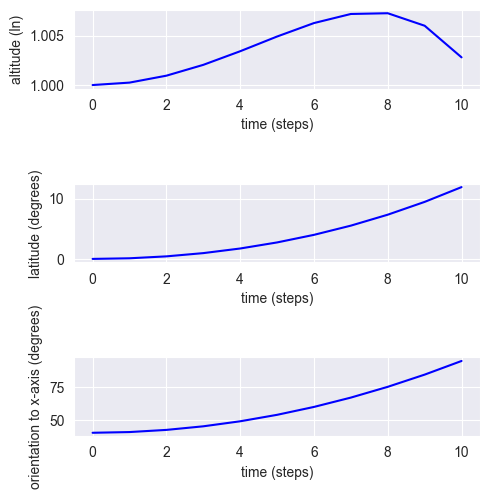

In [168]:
test_env.render(sample_traj_rate = 1)

In [169]:
traj_a[:,0]

array([1.4999998, 1.4999998, 1.4999998, 1.4999998, 1.4999998, 1.4999998,
       1.4999998, 1.4999998, 1.4999998, 1.5      , 1.5      , 1.5      ,
       1.5      , 1.5      , 1.5      , 1.5      , 1.5      , 1.5      ,
       1.5      , 1.5      , 1.5      , 1.5      , 1.5      , 1.5      ,
       1.5      , 1.5      , 1.5      , 1.5      , 1.5      , 1.5      ,
       1.5      , 1.5      , 1.5      , 1.5      , 1.5      , 1.5      ,
       1.5      , 1.5      , 1.5      , 1.5      , 1.5      , 1.5      ,
       1.5      , 1.5      , 1.5      , 1.5      , 1.5      , 1.5      ,
       1.5      , 1.5      , 1.5      , 1.5      , 1.5      ],
      dtype=float32)

In [170]:
traj_a[:,1]

array([5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5.], dtype=float32)

In [73]:
many_traj = []
many_a = []

for _ in range(1):
    traj = []
    a_history = []
    
    s = test_env.reset()
    while True:
        traj.append(s)
    
        s_v = torch.FloatTensor([s]).to(device)
        a_v = act_net(s_v)
        a = a_v.data.cpu().numpy()[0]
        a_history.append( np.clip(a, -test_env.max_thrust, test_env.max_thrust))
    
        s,r,d,_ = test_env.step(a)
        if d:
            break

    many_traj.append(np.array(traj))
    many_a.append(np.array(a_history))

many_traj = np.array(many_traj)
many_a = np.array(many_a)

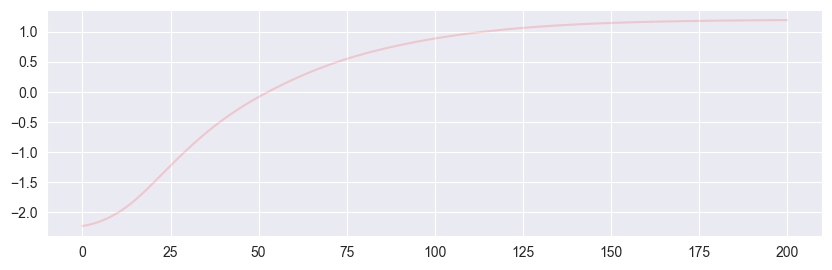

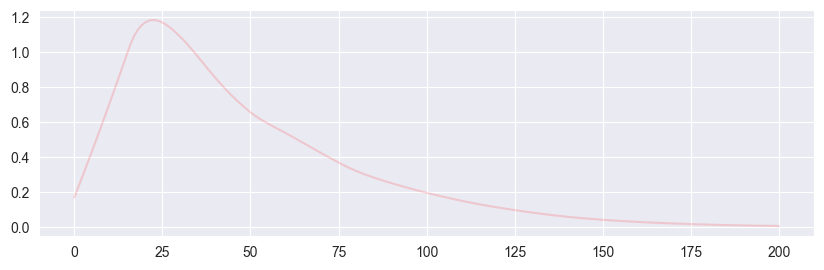

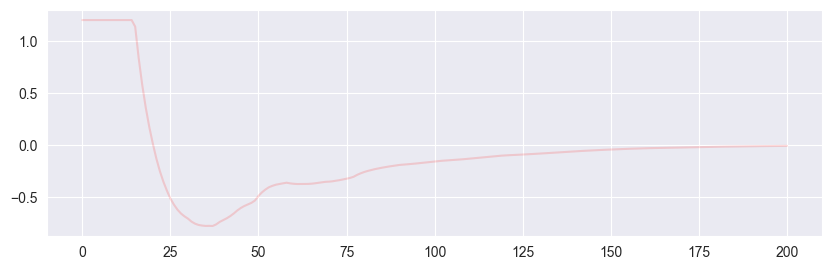

In [344]:
plt.figure(figsize=(10,3), dpi=100)
plt.plot(many_traj[:,:,0].T, color='r', alpha=0.15);
plt.show();

plt.figure(figsize=(10,3), dpi=100)
plt.plot(many_traj[:,:,1].T, color='r', alpha=0.15);
plt.show()

plt.figure(figsize=(10,3), dpi=100)
plt.plot(many_a[:,:,0].T, color='r', alpha=0.15);
plt.show()